In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN_int import *
from NN_library.train_dual_PINN_int import *
from matplotlib.tri import Triangulation
from utility import *
from PDE_losses import PDE_loss, PDE_loss_dual
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

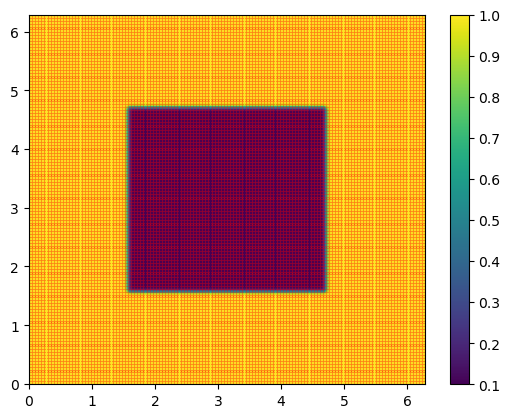

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

eps = 30
def a_function(x,y):
    x_dir = 0.5 + 0.5*np.tanh(eps*np.sin(x-np.pi/2))
    y_dir = 0.5 + 0.5*np.tanh(eps*np.sin(y-np.pi/2))
    a = 1 - 0.9*x_dir*y_dir
    return a

def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Primal PINN

In [4]:
net_primal = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{eps}_{total_params}'}

Number of parameters: 1801


In [7]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [5]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  6.72402802e+01, bound:  7.65580058e-01
Epoch: 1 mean train loss:  6.68301468e+01, bound:  7.65664518e-01
Epoch: 2 mean train loss:  6.64236450e+01, bound:  7.65752256e-01
Epoch: 3 mean train loss:  6.60209198e+01, bound:  7.65844464e-01
Epoch: 4 mean train loss:  6.56221008e+01, bound:  7.65940845e-01
Epoch: 5 mean train loss:  6.52272949e+01, bound:  7.66040742e-01
Epoch: 6 mean train loss:  6.48365936e+01, bound:  7.66143262e-01
Epoch: 7 mean train loss:  6.44500732e+01, bound:  7.66247511e-01
Epoch: 8 mean train loss:  6.40677795e+01, bound:  7.66352773e-01
Epoch: 9 mean train loss:  6.36897659e+01, bound:  7.66458213e-01
Epoch: 10 mean train loss:  6.33160439e+01, bound:  7.66563416e-01
Epoch: 11 mean train loss:  6.29466515e+01, bound:  7.66667902e-01
Epoch: 12 mean train loss:  6.25816002e+01, bound:  7.66771436e-01
Epoch: 13 mean train loss:  6.22208939e+01, bound:  7.66873896e-01
Epoch: 14 mean train loss:  6.18645477e+01, bound:  7.66975164e-01
Epoch

In [6]:
np.save(f'NN_library/training_data/square/PINN_primal_{eps}_{total_params}', np.vstack([losses_train, losses_val]))

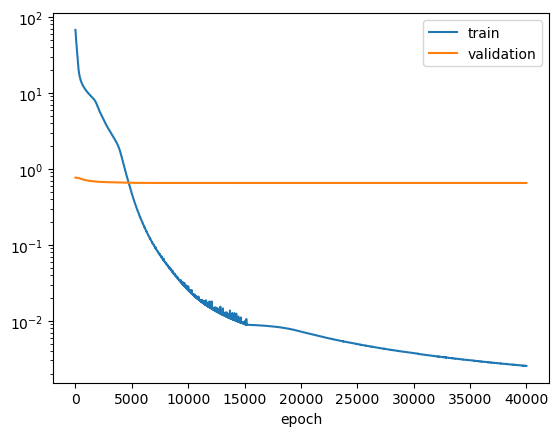

In [7]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [8]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _, _ = PDE_loss(grid_data, net_primal, A, H1)

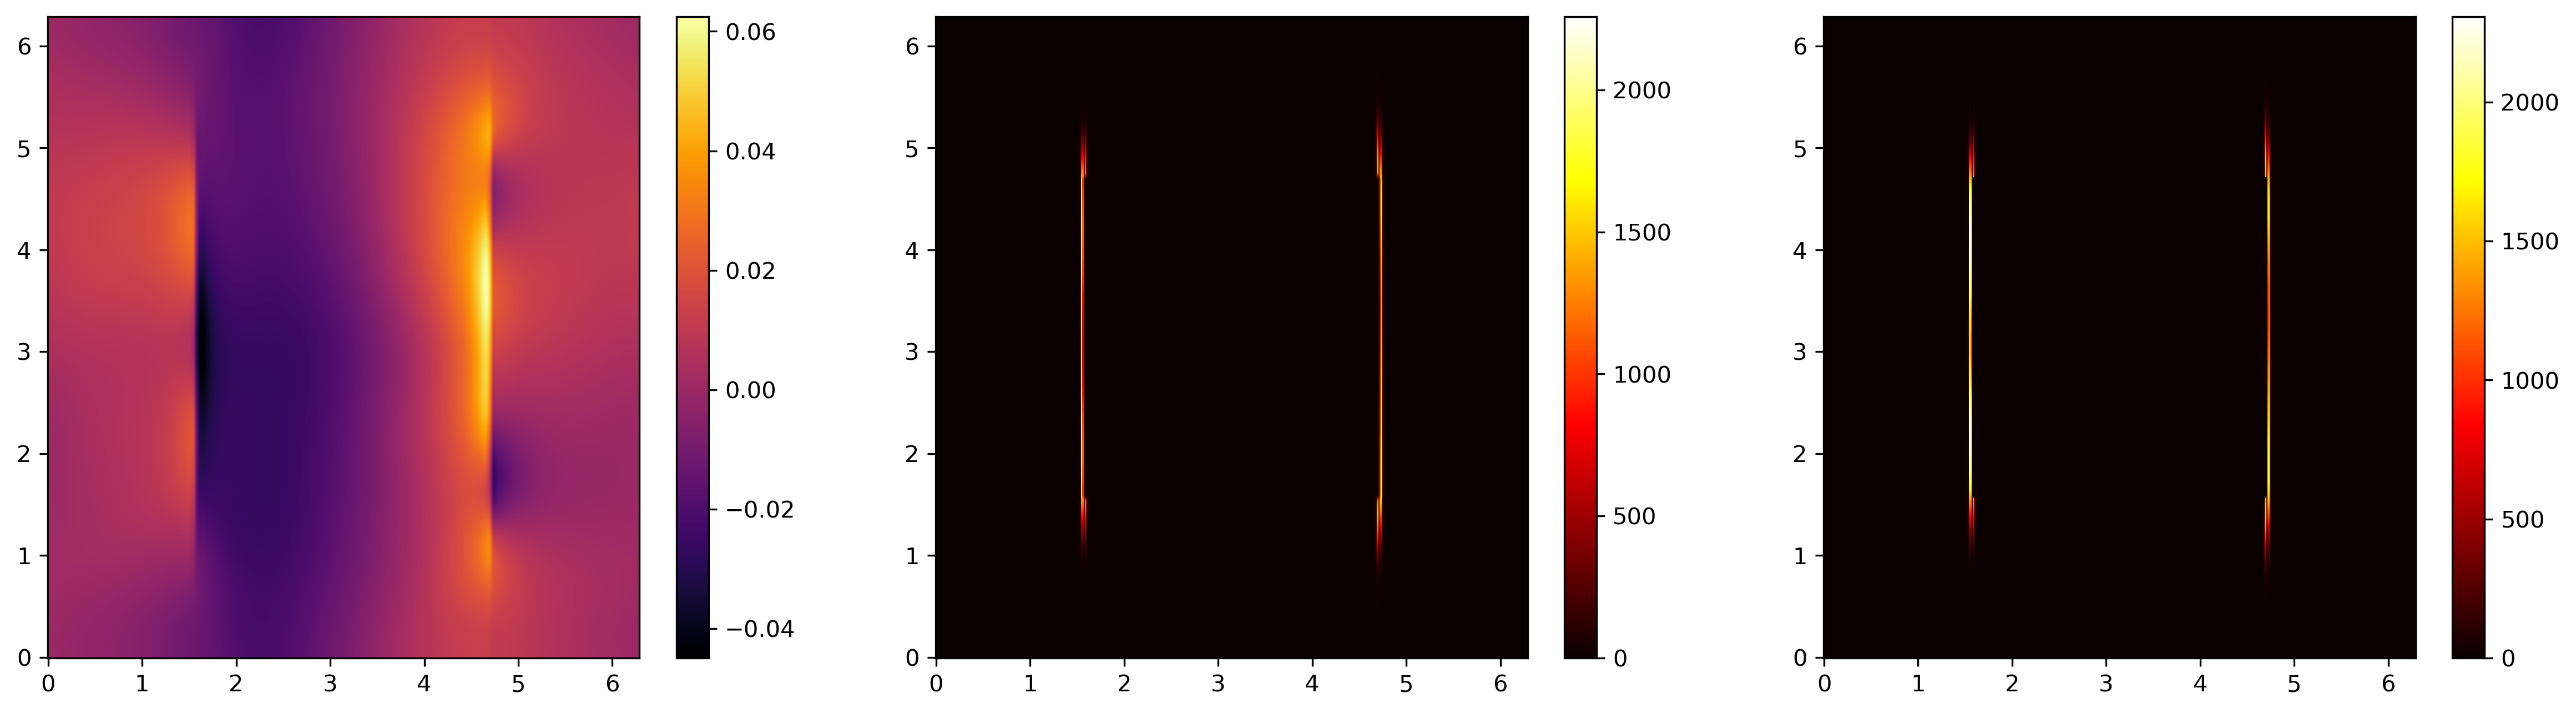

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [8]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach().item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)

bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_PINN_{total_params}_{eps}.npy', (bound_1, bound_2))

0.6505317687988281
0.6491309699215345


# Dual PINN

In [9]:
net_dual = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{eps}_{total_params}'}

Number of parameters: 1801


In [ ]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [10]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  5.65664600e+03, bound:  2.93141156e-01
Epoch: 1 mean train loss:  5.64058691e+03, bound:  2.93418288e-01
Epoch: 2 mean train loss:  5.62461621e+03, bound:  2.93698907e-01
Epoch: 3 mean train loss:  5.60873438e+03, bound:  2.93982267e-01
Epoch: 4 mean train loss:  5.59294189e+03, bound:  2.94267952e-01
Epoch: 5 mean train loss:  5.57724316e+03, bound:  2.94556081e-01
Epoch: 6 mean train loss:  5.56164062e+03, bound:  2.94846773e-01
Epoch: 7 mean train loss:  5.54613965e+03, bound:  2.95140088e-01
Epoch: 8 mean train loss:  5.53074219e+03, bound:  2.95435786e-01
Epoch: 9 mean train loss:  5.51545508e+03, bound:  2.95733571e-01
Epoch: 10 mean train loss:  5.50028174e+03, bound:  2.96033084e-01
Epoch: 11 mean train loss:  5.48522754e+03, bound:  2.96334118e-01
Epoch: 12 mean train loss:  5.47029492e+03, bound:  2.96636283e-01
Epoch: 13 mean train loss:  5.45548877e+03, bound:  2.96939403e-01
Epoch: 14 mean train loss:  5.44081396e+03, bound:  2.97243118e-01
Epoch

In [11]:
np.save(f'NN_library/training_data/square/PINN_dual_{eps}_{total_params}', np.vstack([losses_train, losses_val]))

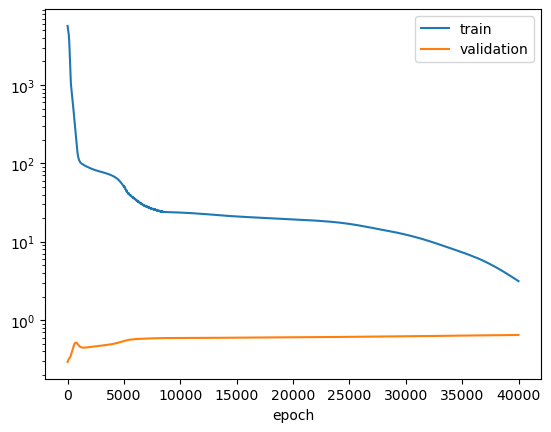

In [12]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [16]:
W1 = net_dual(grid_data).detach().cpu()
error_1, _, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

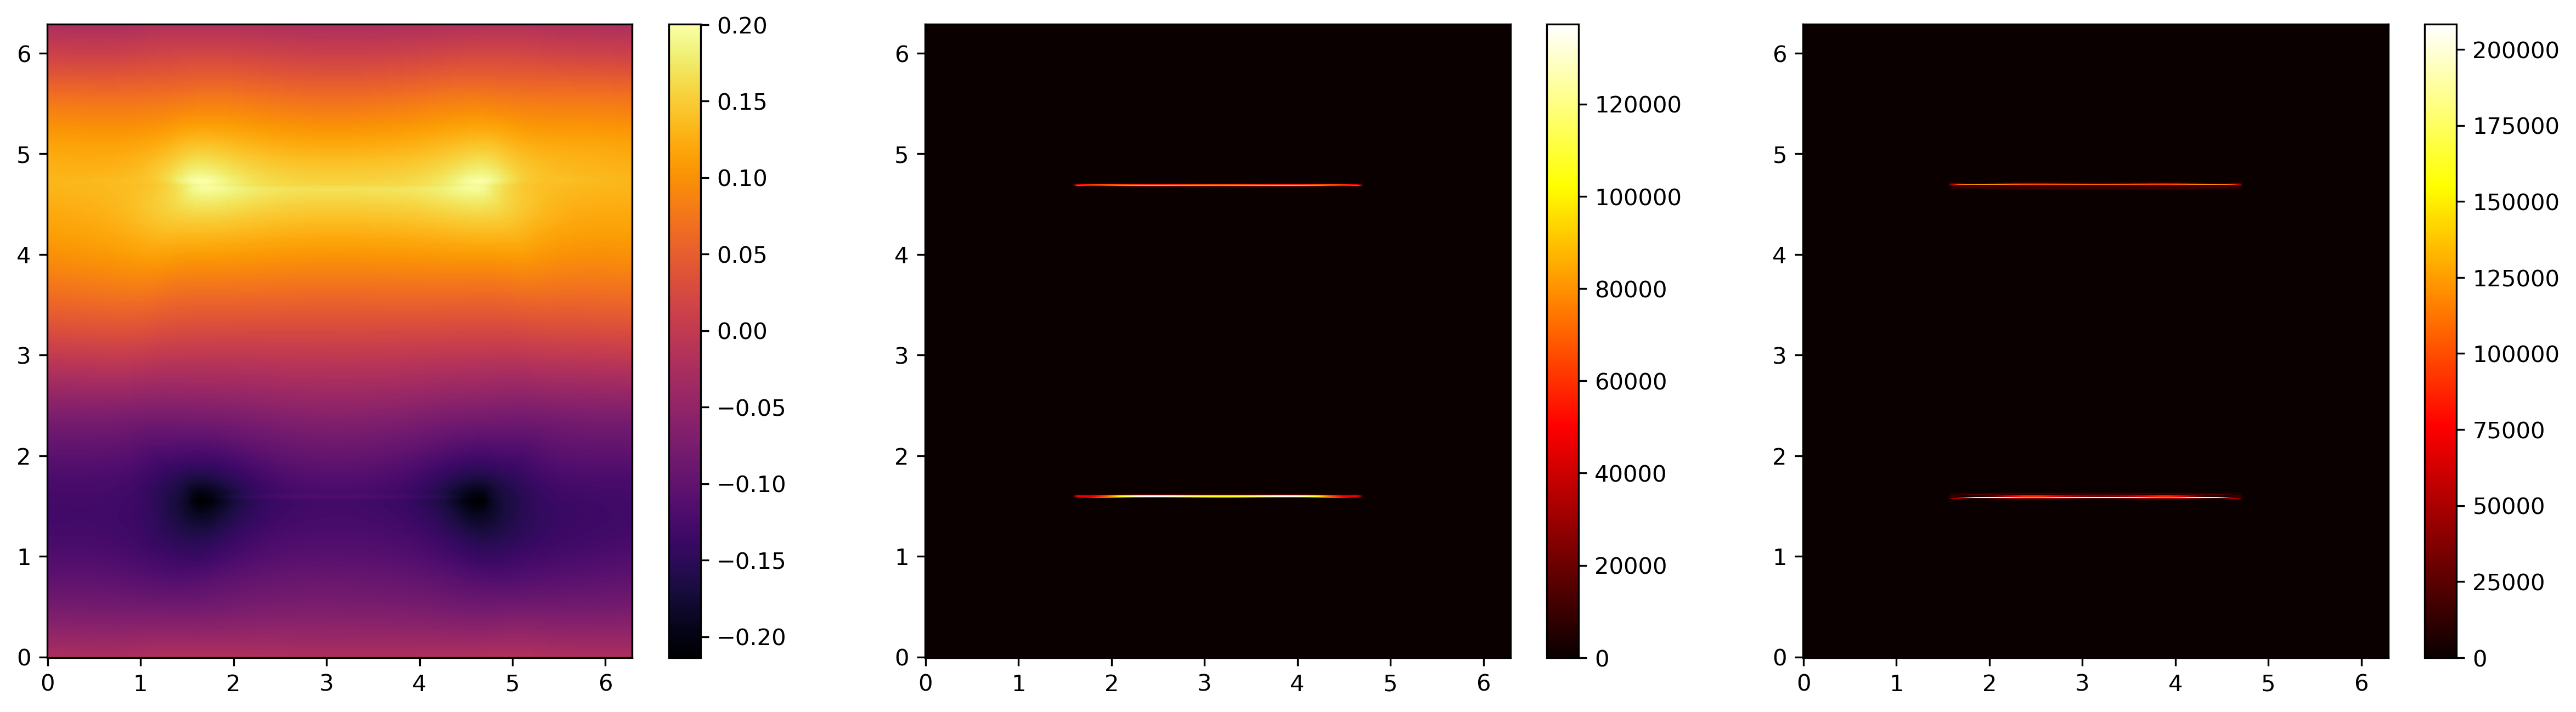

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], W1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [13]:
_, q2, gH = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach().item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_PINN_{total_params}_{eps}.npy', (1/bound_1, bound_2))

0.6463832515960765
0.6371657371980857
